In [1]:
import numpy as np 
from models import *
from priors_new import *
from theoretical_vs_learned_comparison import *
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
model_prior = GaussianMixture(latent_dim=1, num_clusters=5)
model_encoder = build_encoder(dim_x=100, h_dim=64, n_layers=2)
model_decoder = build_decoder(dim_x=100, latent_dim=1, h_dim=64, n_layers=2)
#opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
model = EmpiricalBayesVariationalAutoencoder(encoder=model_encoder, enc_out_dim=64, decoder=model_decoder, prior=model_prior)

In [3]:
def make_features(z, labels, centers, *, 
                  D, K, seed, 
                  n_linear=0, n_monotone=20, n_bump_per_cluster=10, 
                  n_periodic=20, n_noise=20, 
                  tau=None, freq_lo=0.6, freq_hi=1.2,
                  sigma_x=0.5, device="cpu"):
    g = torch.Generator(device=device).manual_seed(seed)
    N, dz = z.shape
    z1 = z[:, 0]
    feats = []
    # linear
    if n_linear:
        A = torch.randn(n_linear, dz, generator=g, device=device) / math.sqrt(dz)
        b = torch.randn(n_linear, generator=g, device=device) * 0.2
        feats.append(z @ A.T + b)
    # monotone
    if n_monotone:
        A = torch.randn(n_monotone, dz, generator=g, device=device) / math.sqrt(dz)
        b = torch.randn(n_monotone, generator=g, device=device) * 0.2
        feats.append(torch.tanh(z @ A.T + b))
    # bumps
    if n_bump_per_cluster:
        if tau is None:
            # safe default: a bit broader than cluster spread if you have it
            tau = 2.0 * (z1.std().item() / max(K-1,1))
        for k in range(K):
            dx = z1 - centers[k, 0]
            bump = torch.exp(-0.5 * (dx / tau) ** 2).unsqueeze(1)  # [N,1]
            feats.append(bump.repeat(1, n_bump_per_cluster))
    # periodic (low freq)
    if n_periodic:
        w = torch.empty(n_periodic, device=device).uniform_(freq_lo, freq_hi, generator=g)
        a = torch.randn(n_periodic, dz, generator=g, device=device) / math.sqrt(dz)
        phi = torch.empty(n_periodic, device=device).uniform_(0, 2*math.pi, generator=g)
        phase = (z @ a.T) + phi
        feats.append(torch.cos(phase * w))
    # noise
    if n_noise:
        feats.append(torch.empty(N, n_noise, device=device).uniform_(-0.5, 0.5, generator=g))

    X = torch.cat(feats, dim=1)
    if X.shape[1] < D:
        X = torch.cat([X, torch.zeros(N, D - X.shape[1], device=device)], dim=1)
    elif X.shape[1] > D:
        X = X[:, :D]
    if sigma_x > 0:
        X = X + sigma_x * torch.randn(X.shape, generator=g, device=device)
    return X

@torch.no_grad()
def generate_clustered_gauss_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,          # 1D latent space
    sigma_val: float = 0.2,       # observation noise std for Gaussian in feature space
    cluster_centers=None,         # if None, auto-generate
    cluster_spread: float = 0.2,  # smaller => tighter clusters in latent space
    seed: int = 42,
    device: str = "cpu",
    nonlinear: bool = False,
):
    """
    Build a clean clusterable dataset with 1D latent space:
      z | c ~ N(center[c], cluster_spread^2) in R^latent_dim
      x | z ~ N(W z + b, sigma^2 I) in R^{n_features}
    Returns:
      X [N, D] (float), labels [N] (long), true Z [N, latent_dim], centers [K, latent_dim]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Set cluster centers in latent space (R^{latent_dim})
    if cluster_centers is None:
        # Evenly spaced along the first latent axis; zeros elsewhere if latent_dim>1
        centers_1d = torch.linspace(-2, 2, n_clusters, device=device)
        centers = torch.zeros(n_clusters, latent_dim, device=device)
        centers[:, 0] = centers_1d
    else:
        centers = torch.as_tensor(cluster_centers, dtype=torch.float32, device=device)
        if centers.ndim == 1:
            centers = centers.unsqueeze(1)  # [K,1] if given as list of scalars
        assert centers.shape == (n_clusters, latent_dim), \
            f"centers must be shape ({n_clusters},{latent_dim})"

    # Cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]

    # Latent samples
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]  # shift by cluster centers
    if nonlinear:
        mean_x = make_features(z, labels, centers, D=n_features, K=n_clusters, seed=seed, device=device, \
            n_linear=0,n_monotone=20,n_bump_per_cluster=15,n_periodic=10,n_noise=10)
        W,b = None, None
    else:
        W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
        b = torch.randn(n_features, generator=g, device=device) * 0.2
        mean_x = z @ W.T + b  # [N, D]

    # Gaussian observation noise (isotropic)
    if sigma_val <= 0:
        X = mean_x
    else:
        X = mean_x + sigma_val * torch.randn(mean_x.shape, device=mean_x.device, generator=g)
    return X, labels.to("cpu"), z.to("cpu"), centers.to("cpu"),W,b

In [4]:
if torch.cuda.is_available():
        device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Well-separated centers

X, y, Z_true, true_centers,W,b = generate_clustered_gauss_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    sigma_val=0.5,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device, 
    nonlinear=True,
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")

Using device: cpu
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


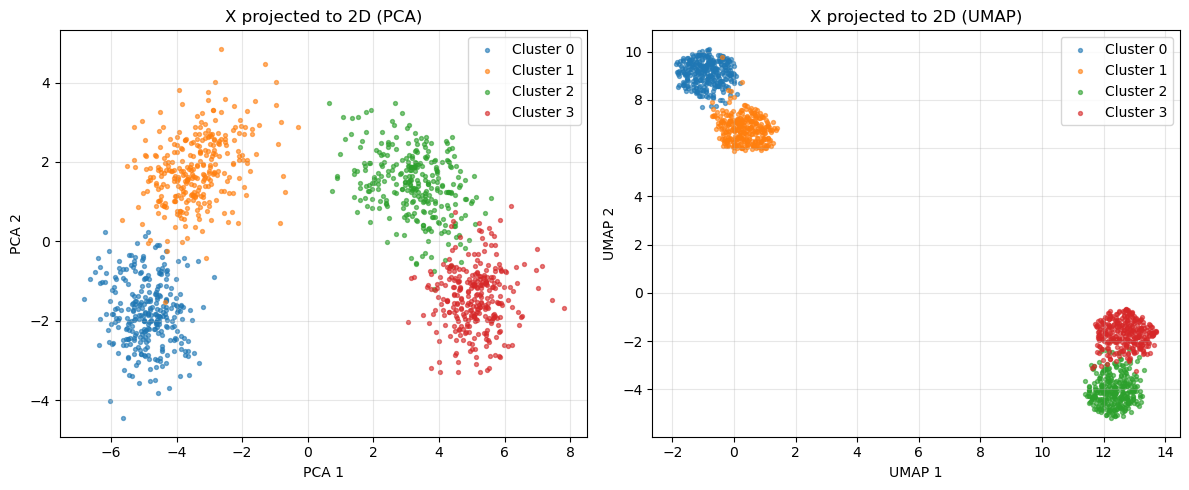

In [5]:
# Visualize X in 2D using PCA and UMAP (if available)
from sklearn.decomposition import PCA

X_np = X.float().cpu().numpy()

# PCA projection to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

plt.figure(figsize=(12,5))

# PCA scatter plot
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = (y.cpu().numpy() == i)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=8, alpha=0.6, label=f"Cluster {i}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("X projected to 2D (PCA)")
plt.legend()
plt.grid(True, alpha=0.3)

# UMAP if available
try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_np)
    plt.subplot(1, 2, 2)
    for i in range(n_clusters):
        mask = (y.cpu().numpy() == i)
        plt.scatter(X_umap[mask, 0], X_umap[mask, 1], s=8, alpha=0.6, label=f"Cluster {i}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title("X projected to 2D (UMAP)")
    plt.legend()
    plt.grid(True, alpha=0.3)
except ImportError:
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, "UMAP not installed", fontsize=14, ha='center', va='center')
    plt.axis("off")
    plt.title("UMAP projection unavailable")

plt.tight_layout()
plt.show()

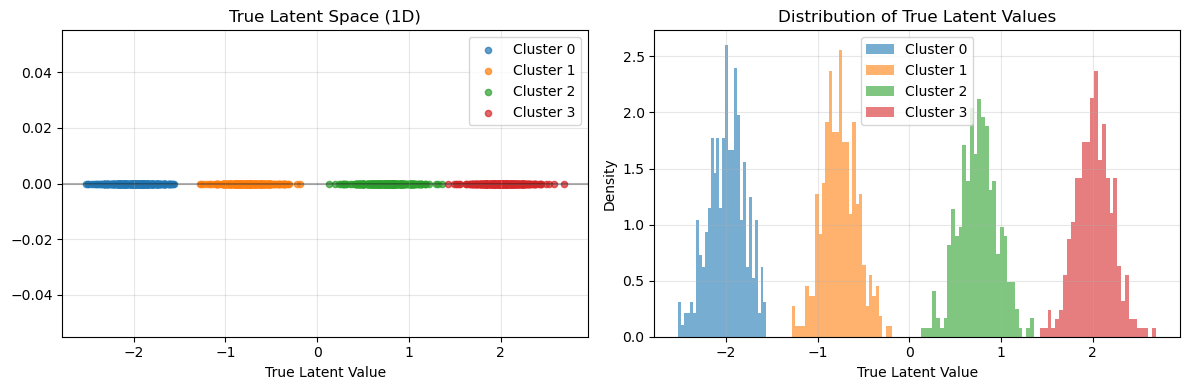

In [6]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0].to("cpu"), np.zeros_like(Z_true[mask, 0].to("cpu")), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0].to("cpu"), bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

In [8]:
model.to(device)

EmpiricalBayesVariationalAutoencoder(
  (prior): GaussianMixture()
  (decoder): DiagGaussianDecoder(
    (backbone): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU(inplace=True)
    )
    (mu_head): Linear(in_features=64, out_features=100, bias=True)
    (logvar_head): Linear(in_features=64, out_features=100, bias=True)
  )
  (qz_head): DiagGaussianHead(
    (proj): Linear(in_features=64, out_features=2, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
  )
)

In [9]:
model.train()
epochs, kl_warm = 500, 50
losses_history = []

print("Starting training...")
for ep in range(1, epochs+1):
    #kl_w = min(21.0, ep / kl_warm)
    kl_w = 1
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        outputs = model.train_step(xb, opt)
        losses={"loss":outputs["vae-loss"]}
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    if ep == 1 or ep % 20 == 0 or ep == epochs:
        #print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}  recon={epoch_losses.get('recon', 0):.3f}  kl={epoch_losses.get('kl', 0):.3f}")
        print(f"[{ep:03d}] loss={tot/n:.3f}")

print("Training completed!")


Starting training...
[001] loss=2250.596
[020] loss=130.451
[040] loss=127.476
[060] loss=126.260
[080] loss=125.813
[100] loss=125.548
[120] loss=125.394
[140] loss=124.662
[160] loss=114.224
[180] loss=113.761
[200] loss=113.718
[220] loss=113.786
[240] loss=113.795
[260] loss=113.702
[280] loss=113.880
[300] loss=113.365
[320] loss=113.063
[340] loss=112.771
[360] loss=112.978
[380] loss=112.519
[400] loss=112.539
[420] loss=112.288
[440] loss=112.346
[460] loss=112.244
[480] loss=112.041
[500] loss=112.008
Training completed!


In [89]:
model.eval()
with torch.no_grad():
    mu_q = model._define_variational_family(X.float().to(device)).mean

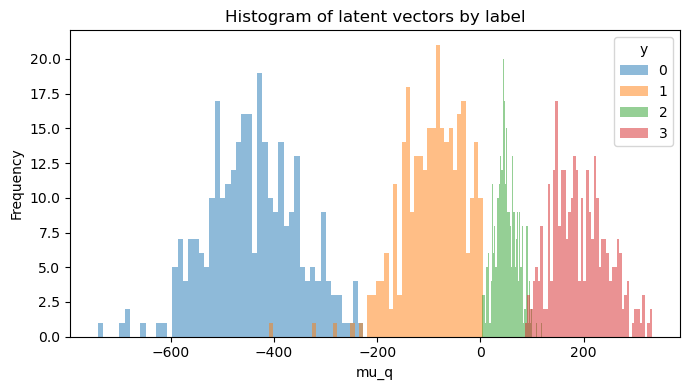

In [90]:
mu = mu_q.detach().flatten().to("cpu").numpy()
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# choose common bin edges so all histograms align
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [61]:
mu_q = mu_q.unsqueeze(1)

In [62]:
resp = model.prior.log_prob_c_z(mu_q)

In [63]:
model.prior.mu

Parameter containing:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [7.4819],
        [0.0000]], requires_grad=True)

In [64]:
predict_label = resp.argmax(dim=1).detach().cpu().numpy()

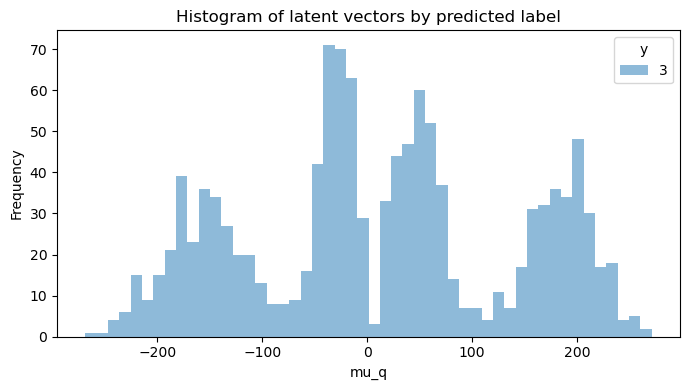

In [65]:
bins = np.histogram_bin_edges(mu, bins="auto")

# --- plot ---
plt.figure(figsize=(7,4))
for lab in np.unique(predict_label):
    sel = (predict_label == lab)
    plt.hist(mu[sel], bins=50, alpha=0.5, label=str(lab))  # counts (frequency)

plt.xlabel("mu_q")
plt.ylabel("Frequency")
plt.title("Histogram of latent vectors by predicted label")
plt.legend(title="y")
plt.tight_layout()
plt.show()

In [66]:
np.where(predict_label==3)

(array([   0,    1,    2, ..., 1197, 1198, 1199], shape=(1200,)),)

In [67]:
resp

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]], grad_fn=<ExpBackward0>)

In [68]:
def calculate_mixture_proportion_comparison(gmm, cluster_assignments, true_labels, n_components):
    """
    Compare GMM mixture proportions with actual cluster proportions.
    
    Parameters:
    - gmm: Fitted GMM model
    - cluster_assignments: GMM cluster assignments
    - true_labels: True cluster labels
    - n_components: Number of GMM components
    
    Returns:
    - dict with mixture proportion comparison metrics
    """
    try:
        # Get GMM mixture proportions (weights)
        gmm_proportions = gmm.weights_
        
        # Calculate actual cluster proportions
        cluster_counts = np.bincount(true_labels.astype(int))
        cluster_proportions = cluster_counts / np.sum(cluster_counts)
        
        # Pad cluster_proportions if it has fewer components than GMM
        if len(cluster_proportions) < n_components:
            padded_cluster = np.zeros(n_components)
            padded_cluster[:len(cluster_proportions)] = cluster_proportions
            cluster_proportions = padded_cluster
        elif len(cluster_proportions) > n_components:
            # Truncate if cluster has more components
            cluster_proportions = cluster_proportions[:n_components]
            cluster_proportions = cluster_proportions / np.sum(cluster_proportions)
        
        # Calculate Jensen-Shannon Divergence (symmetric version of KL divergence)
        js_divergence = jensenshannon(gmm_proportions, cluster_proportions)
        
        # Calculate KL Divergence (GMM -> Cluster)
        kl_divergence = entropy(gmm_proportions, cluster_proportions)
        
        # Calculate KL Divergence (Cluster -> GMM) for symmetry
        kl_divergence_reverse = entropy(cluster_proportions, gmm_proportions)
        
        # Calculate correlation between proportions
        correlation = np.corrcoef(gmm_proportions, cluster_proportions)[0, 1]
        
        # Calculate mean absolute error
        mae = np.mean(np.abs(gmm_proportions - cluster_proportions))
        
        # Calculate root mean square error
        rmse = np.sqrt(np.mean((gmm_proportions - cluster_proportions) ** 2))
        
        return {
            'js_divergence': js_divergence,
            'kl_divergence_gmm_to_cluster': kl_divergence,
            'kl_divergence_cluster_to_gmm': kl_divergence_reverse,
            'proportion_correlation': correlation,
            'proportion_mae': mae,
            'proportion_rmse': rmse,
            'gmm_proportions': gmm_proportions.tolist(),
            'cluster_proportions': cluster_proportions.tolist()
        }
        
    except Exception as e:
        print(f"Error calculating mixture proportion comparison: {e}")
        return {
            'js_divergence': np.nan,
            'kl_divergence_gmm_to_cluster': np.nan,
            'kl_divergence_cluster_to_gmm': np.nan,
            'proportion_correlation': np.nan,
            'proportion_mae': np.nan,
            'proportion_rmse': np.nan,
            'gmm_proportions': [],
            'cluster_proportions': []
        }


In [69]:
# Import additional libraries for GMM analysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
import warnings
warnings.filterwarnings('ignore')

def fit_gmm_and_analyze(latent_data, true_labels, n_components, model_name="unknown"):
    """
    Fit GMM to latent data and calculate various metrics.
    
    Parameters:
    - latent_data: numpy array of latent embeddings
    - true_labels: true cluster labels
    - n_components: number of GMM components
    - model_name: name of the model for logging
    
    Returns:
    - dict with GMM metrics
    """
    try:
        # Ensure we have enough data points for the number of components
        if len(latent_data) < n_components:
            print(f"Warning: Not enough data points ({len(latent_data)}) for {n_components} components in {model_name}")
            return None
        
        # Fit GMM
        gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=200)
        gmm.fit(latent_data)
        
        # Get probabilities for each data point
        probabilities = gmm.predict_proba(latent_data)  # shape: (n_samples, n_components)
        
        # Calculate entropy for each data point
        point_entropies = [entropy(probs) for probs in probabilities]
        
        # Calculate max probability to cluster for each data point
        max_probabilities = np.max(probabilities, axis=1)
        
        # Calculate goodness of fit metrics
        bic = gmm.bic(latent_data)
        aic = gmm.aic(latent_data)
        
        # Calculate additional goodness of fit metrics
        log_likelihood = gmm.score(latent_data)
        perplexity = np.exp(-log_likelihood / len(latent_data))
        
        # Get cluster assignments
        cluster_assignments = gmm.predict(latent_data)
        
        # Calculate silhouette score
        if len(set(cluster_assignments)) > 1:  # Need at least 2 clusters for silhouette
            silhouette = silhouette_score(latent_data, cluster_assignments)
        else:
            silhouette = np.nan
        
        # Calculate Calinski-Harabasz index
        if len(set(cluster_assignments)) > 1:
            calinski_harabasz = calinski_harabasz_score(latent_data, cluster_assignments)
        else:
            calinski_harabasz = np.nan
        
        # Calculate Davies-Bouldin index
        if len(set(cluster_assignments)) > 1:
            davies_bouldin = davies_bouldin_score(latent_data, cluster_assignments)
        else:
            davies_bouldin = np.nan
        
        # Calculate ARI with true labels
        ari_with_true = adjusted_rand_score(cluster_assignments, true_labels)
        
        # Calculate mixture proportion comparison
        mixture_proportion_metrics = calculate_mixture_proportion_comparison(
            gmm, cluster_assignments, true_labels, n_components
        )
        
        # Calculate distribution statistics for entropy
        entropy_stats = {
            'mean_entropy': np.mean(point_entropies),
            'std_entropy': np.std(point_entropies),
            'min_entropy': np.min(point_entropies),
            'max_entropy': np.max(point_entropies),
            'median_entropy': np.median(point_entropies)
        }
        
        # Calculate distribution statistics for max probabilities
        max_prob_stats = {
            'mean_max_prob': np.mean(max_probabilities),
            'std_max_prob': np.std(max_probabilities),
            'min_max_prob': np.min(max_probabilities),
            'max_max_prob': np.max(max_probabilities),
            'median_max_prob': np.median(max_probabilities)
        }
        
        return {
            'n_components': n_components,
            'n_samples': len(latent_data),
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood,
            'perplexity': perplexity,
            'silhouette_score': silhouette,
            'calinski_harabasz': calinski_harabasz,
            'davies_bouldin': davies_bouldin,
            'ari_with_true': ari_with_true,
            'converged': gmm.converged_,
            'n_iter': gmm.n_iter_,
            **entropy_stats,
            **max_prob_stats,
            **mixture_proportion_metrics
        }
        
    except Exception as e:
        print(f"Error fitting GMM for {model_name}: {e}")
        return None


In [70]:
# Train the VAE model with early stopping
print("Training VAE model...")
model.train()
epochs, kl_warm = 500, 50
losses_history = []

# Early stopping parameters
patience = 100  # Number of epochs to wait for improvement
min_delta = 1e-4  # Minimum change to qualify as an improvement
best_loss = float('inf')
patience_counter = 0
early_stop = False

for epoch in range(1, epochs+1):
    kl_w = 1
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        loss,_ = model.variational_inference_step(xb, opt)
        losses={"loss":loss}
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    current_loss = tot/n
    
    # Early stopping check
    if current_loss < best_loss - min_delta:
        best_loss = current_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
        print(f"[{epoch:03d}] loss={current_loss:.3f} (best: {best_loss:.3f}, patience: {patience_counter}/{patience})")
    
    # Check for early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch} (patience: {patience})")
        early_stop = True
        break

if not early_stop:
    print("Training completed!")
else:
    print(f"Training stopped early at epoch {epoch}")

print(f"Final loss: {current_loss:.4f}, Best loss: {best_loss:.4f}")
print(f"Total epochs: {epoch}")


Training VAE model...
[001] loss=110.382 (best: 110.382, patience: 0/100)
[020] loss=110.688 (best: 110.312, patience: 3/100)
[040] loss=110.599 (best: 110.312, patience: 23/100)
[060] loss=110.735 (best: 110.312, patience: 43/100)
[080] loss=110.521 (best: 110.251, patience: 14/100)
[100] loss=110.440 (best: 110.251, patience: 34/100)
[120] loss=110.545 (best: 110.251, patience: 54/100)
[140] loss=110.749 (best: 110.251, patience: 74/100)
[160] loss=110.419 (best: 110.251, patience: 94/100)
Early stopping at epoch 166 (patience: 100)
Training stopped early at epoch 166
Final loss: 110.4724, Best loss: 110.2515
Total epochs: 166


Extracting learned latent representations...
Learned latent (sampled) shape: (1200,)
Learned latent (sampled) range: [-428.048, 425.724]
Learned latent (mean) shape: (1200,)
Learned latent (mean) range: [-310.466, 338.814]


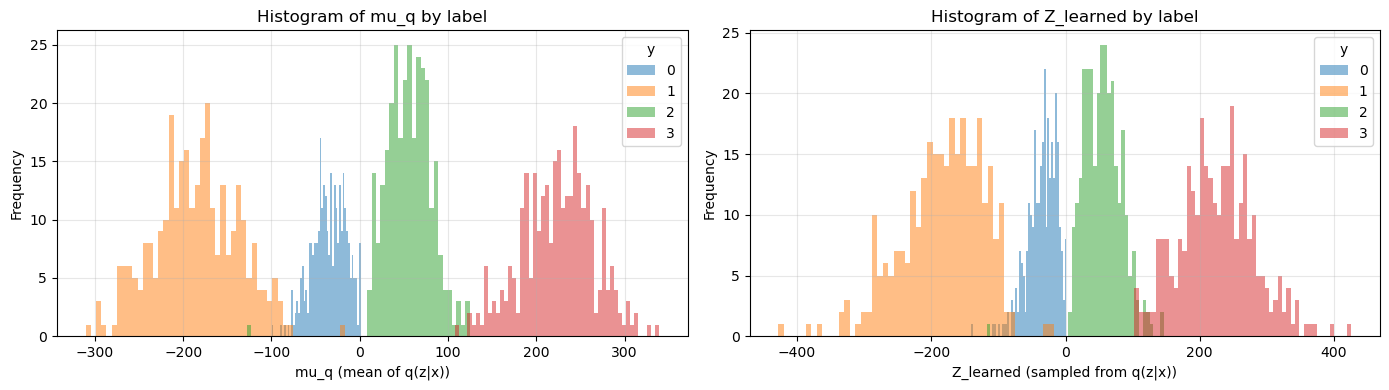

In [71]:
print("Extracting learned latent representations...")
model.eval()
with torch.no_grad():
    # Get the variational posterior q(z|x)
    qz_x = model._define_variational_family(X.float().to(device))
    
    # Get the mean (mu_q) and sample from the distribution
    mu_q = qz_x.mean  # Mean of q(z|x)
    Z_learned = qz_x.sample()  # Sample from q(z|x) - this is what we want for GMM analysis
    
    # Convert to numpy
    mu_learned = mu_q.detach().flatten().to("cpu").numpy()
    Z_learned = Z_learned.detach().flatten().to("cpu").numpy()
    
labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

print(f"Learned latent (sampled) shape: {Z_learned.shape}")
print(f"Learned latent (sampled) range: [{Z_learned.min():.3f}, {Z_learned.max():.3f}]")
print(f"Learned latent (mean) shape: {mu_learned.shape}")
print(f"Learned latent (mean) range: [{mu_learned.min():.3f}, {mu_learned.max():.3f}]")

# --- plot comparison ---
plt.figure(figsize=(14, 4))

# Plot 1: Mean of variational posterior
plt.subplot(1, 2, 1)
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(mu_learned[sel], bins=50, alpha=0.5, label=str(lab))
plt.xlabel("mu_q (mean of q(z|x))")
plt.ylabel("Frequency")
plt.title("Histogram of mu_q by label")
plt.legend(title="y")
plt.grid(True, alpha=0.3)

# Plot 2: Sampled latent values
plt.subplot(1, 2, 2)
for lab in np.unique(labels):
    sel = (labels == lab)
    plt.hist(Z_learned[sel], bins=50, alpha=0.5, label=str(lab))
plt.xlabel("Z_learned (sampled from q(z|x))")
plt.ylabel("Frequency")
plt.title("Histogram of Z_learned by label")
plt.legend(title="y")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
# Perform GMM analysis on true latent space
print("Analyzing GMM on true latent space...")
true_gmm_results = fit_gmm_and_analyze(
    Z_true.cpu().numpy(), 
    y.cpu().numpy(), 
    n_clusters, 
    "True_Latent"
)

if true_gmm_results:
    print("True Latent GMM Results:")
    for key, value in true_gmm_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
else:
    print("Failed to analyze true latent space")


Analyzing GMM on true latent space...
True Latent GMM Results:
  n_components: 4
  n_samples: 1200
  bic: 2951.5450
  aic: 2895.55419921875
  log_likelihood: -1.1973142623901367
  perplexity: 1.0009982585906982
  silhouette_score: 0.8049
  calinski_harabasz: 22612.9492
  davies_bouldin: 0.2562
  ari_with_true: 1.0000
  converged: True
  n_iter: 2
  mean_entropy: 0.0026246956549584866
  std_entropy: 0.028731688857078552
  min_entropy: 7.832738126991538e-16
  max_entropy: 0.6461809277534485
  median_entropy: 2.3016417571852799e-07
  mean_max_prob: 0.9991599321365356
  std_max_prob: 0.012397779151797295
  min_max_prob: 0.6520299911499023
  max_max_prob: 1.0
  median_max_prob: 1.0
  js_divergence: 0.0002
  kl_divergence_gmm_to_cluster: 0.0000
  kl_divergence_cluster_to_gmm: 0.0000
  proportion_correlation: nan
  proportion_mae: 0.0001
  proportion_rmse: 0.0001
  gmm_proportions: [0.24988116323947906, 0.2498723566532135, 0.25011515617370605, 0.2501313388347626]
  cluster_proportions: [0.25,

In [35]:
# Perform GMM analysis on learned latent space
Z_learned = Z_learned.reshape(-1, 1)
print("Analyzing GMM on learned latent space...")
learned_gmm_results = fit_gmm_and_analyze(
    Z_learned, 
    y.cpu().numpy(), 
    n_clusters, 
    "Learned_Latent"
)

if learned_gmm_results:
    print("Learned Latent GMM Results:")
    for key, value in learned_gmm_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
else:
    print("Failed to analyze learned latent space")


Analyzing GMM on learned latent space...
Learned Latent GMM Results:
  n_components: 4
  n_samples: 1200
  bic: 13630.0807
  aic: 13574.08984375
  log_likelihood: -5.646704196929932
  perplexity: 1.0047166347503662
  silhouette_score: 0.6308
  calinski_harabasz: 3664.9146
  davies_bouldin: 0.4961
  ari_with_true: 0.5611
  converged: True
  n_iter: 5
  mean_entropy: 0.1813068985939026
  std_entropy: 0.22198359668254852
  min_entropy: 1.4164492579238511e-21
  max_entropy: 0.8024985194206238
  median_entropy: 0.07002013176679611
  mean_max_prob: 0.9299349188804626
  std_max_prob: 0.11553054302930832
  min_max_prob: 0.49781349301338196
  max_max_prob: 1.0
  median_max_prob: 0.9872526526451111
  js_divergence: 0.2228
  kl_divergence_gmm_to_cluster: 0.2002
  kl_divergence_cluster_to_gmm: 0.2072
  proportion_correlation: nan
  proportion_mae: 0.1344
  proportion_rmse: 0.1634
  gmm_proportions: [0.5144484639167786, 0.2544081509113312, 0.13359352946281433, 0.09754986315965652]
  cluster_proport

In [36]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import math
from typing import Tuple, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Import the existing modules
from models import *
from priors_new import *
# Import the comparison functions and classes from the Python script
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('theoretical_vs_learned_comparison.py')))

# Import the main comparison function and classes
from theoretical_vs_learned_comparison import (
    generate_clustered_gauss_1d, 
    TheoreticalOptimalModel, 
    TheoreticalVAE, 
    compare_models
)

print("Successfully imported comparison functions from Python script!")



Successfully imported comparison functions from Python script!


In [37]:
print("Running theoretical vs learned comparison...")
results = compare_models(X, y, Z_true, W, b, 0.5, device)

Running theoretical vs learned comparison...
THEORETICAL vs LEARNED ENCODER/DECODER COMPARISON

1. THEORETICAL OPTIMAL MODEL
----------------------------------------


TypeError: pinverse(): argument 'input' (position 1) must be Tensor, not NoneType

In [38]:
# Display detailed results summary
print("\n" + "="*80)
print("DETAILED RESULTS SUMMARY")
print("="*80)

print(f"\nRECONSTRUCTION PERFORMANCE:")
print(f"  Theoretical MSE: {results['theoretical']['recon_error']:.6f}")
print(f"  Learned MSE:    {results['learned']['recon_error']:.6f}")
print(f"  Performance gap: {results['learned']['recon_error'] / results['theoretical']['recon_error']:.2f}x worse")

print(f"\nLATENT QUALITY:")
print(f"  Theoretical correlation: {results['theoretical']['latent_corr']:.6f}")
print(f"  Learned correlation:    {results['learned']['latent_corr']:.6f}")
print(f"  Correlation difference: {results['theoretical']['latent_corr'] - results['learned']['latent_corr']:.6f}")

print(f"\nELBO LOSSES:")
print(f"  Theoretical: {results['theoretical']['elbo_loss']:.6f}")
print(f"  Learned:    {results['learned']['elbo_loss']:.6f}")
print(f"  Loss ratio: {results['learned']['elbo_loss'] / results['theoretical']['elbo_loss']:.2f}x worse")

print(f"\nEXPECTED LOG LIKELIHOOD:")
print(f"  Theoretical: {results['theoretical']['expected_log_lik']:.6f}")
print(f"  Learned:    {results['learned']['expected_log_lik']:.6f}")

print(f"\nKL DIVERGENCE:")
print(f"  Theoretical: {results['theoretical']['dkl']:.6f}")
print(f"  Learned:    {results['learned']['dkl']:.6f}")

print(f"\nKEY INSIGHTS:")
print(f"  • The learned model has {results['learned']['recon_error'] / results['theoretical']['recon_error']:.1f}x worse reconstruction")
print(f"  • The learned model has {results['learned']['elbo_loss'] / results['theoretical']['elbo_loss']:.1f}x higher ELBO loss")
print(f"  • The learned model achieves {results['learned']['latent_corr']:.1%} correlation vs {results['theoretical']['latent_corr']:.1%} theoretical")
print(f"  • This shows the learned model deviates significantly from the theoretical optimal")



DETAILED RESULTS SUMMARY

RECONSTRUCTION PERFORMANCE:


NameError: name 'results' is not defined

In [39]:
# Create a summary table for easy comparison
import pandas as pd

# Create comparison table
comparison_data = {
    'Metric': [
        'Reconstruction MSE',
        'Latent Correlation', 
        'ELBO',
        'Expected Log Likelihood',
        'KL Divergence'
    ],
    'Theoretical': [
        f"{results['theoretical']['recon_error']:.6f}",
        f"{results['theoretical']['latent_corr']:.6f}",
        f"{-results['theoretical']['elbo_loss']:.6f}",
        f"{results['theoretical']['expected_log_lik']:.6f}",
        f"{results['theoretical']['dkl']:.6f}"
    ],
    'Learned': [
        f"{results['learned']['recon_error']:.6f}",
        f"{results['learned']['latent_corr']:.6f}",
        f"{-results['learned']['elbo_loss']:.6f}",
        f"{results['learned']['expected_log_lik']:.6f}",
        f"{results['learned']['dkl']:.6f}"
    ],
    'Ratio (Learned/Theoretical)': [
        f"{results['learned']['recon_error'] / results['theoretical']['recon_error']:.2f}x",
        f"{results['learned']['latent_corr'] / results['theoretical']['latent_corr']:.2f}x",
        f"{results['learned']['elbo_loss'] / results['theoretical']['elbo_loss']:.2f}x",
        f"{results['learned']['expected_log_lik'] / results['theoretical']['expected_log_lik']:.2f}x" if results['learned']['expected_log_lik'] != 0 else "N/A",
        f"{results['learned']['dkl'] / results['theoretical']['dkl']:.2f}x" if results['learned']['dkl'] != 0 else "N/A"
    ]
}

df = pd.DataFrame(comparison_data)
print("\nCOMPARISON TABLE:")
print("="*80)
print(df.to_string(index=False))


NameError: name 'results' is not defined

In [ ]:
def run_complete_simulation_analysis(
    n_clusters=4,
    points_per_cluster=300,
    n_features=100,
    latent_dim=1,
    cluster_centers=None,
    cluster_spread=0.2,
    sigma_val=0.5,
    nonlinear=True,
    epochs=500,
    kl_warm=50,
    patience=100,
    min_delta=1e-4,
    lr=5e-4,
    weight_decay=1e-5,
    batch_size=128,
    seed=42,
    device=None,
    show_plots=True,
    save_results=False,
    case_name="simulation"
):
    """
    Complete simulation analysis function that generates data, trains model, and creates all visualizations.
    
    Parameters:
    - n_clusters: Number of clusters to generate
    - points_per_cluster: Number of points per cluster
    - n_features: Number of features in the dataset
    - latent_dim: Dimension of latent space
    - cluster_centers: List of cluster centers (if None, auto-generate)
    - cluster_spread: Spread of clusters in latent space
    - sigma_val: Observation noise standard deviation
    - nonlinear: Whether to use nonlinear feature generation
    - epochs: Maximum number of training epochs
    - kl_warm: KL warmup epochs
    - patience: Early stopping patience
    - min_delta: Minimum change for early stopping
    - lr: Learning rate
    - weight_decay: Weight decay
    - batch_size: Batch size for training
    - seed: Random seed
    - device: Device to use (if None, auto-detect)
    - show_plots: Whether to display plots
    - save_results: Whether to save results
    - case_name: Name for this simulation case
    
    Returns:
    - dict: Complete results including data, model, metrics, and plots
    """
    
    print(f"\n{'='*80}")
    print(f"RUNNING SIMULATION CASE: {case_name}")
    print(f"{'='*80}")
    
    # Set device
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"
    
    print(f"Using device: {device}")
    torch.manual_seed(seed)
    
    # Generate dataset
    print(f"\n1. GENERATING DATASET")
    print("-" * 40)
    
    if cluster_centers is None:
        cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Default well-separated centers
    
    X, y, Z_true, true_centers, W, b = generate_clustered_gauss_1d(
        n_clusters=n_clusters,
        points_per_cluster=points_per_cluster,
        n_features=n_features,
        latent_dim=latent_dim,
        sigma_val=sigma_val,
        cluster_centers=cluster_centers,
        cluster_spread=cluster_spread,
        seed=seed,
        device=device,
        nonlinear=nonlinear,
    )
    
    print(f"Generated dataset:")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    print(f"  Z_true shape: {Z_true.shape}")
    print(f"  True cluster centers: {true_centers.flatten().tolist()}")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Points per cluster: {points_per_cluster}")
    
    # Initialize model
    print(f"\n2. INITIALIZING MODEL")
    print("-" * 40)
    
    model_prior = GaussianMixture(latent_dim=latent_dim, num_clusters=n_clusters)
    model_encoder = build_encoder(dim_x=n_features, h_dim=64, n_layers=2)
    model_decoder = build_decoder(dim_x=n_features, latent_dim=latent_dim, h_dim=64, n_layers=2)
    model = EmpiricalBayesVariationalAutoencoder(
        encoder=model_encoder, 
        enc_out_dim=64, 
        decoder=model_decoder, 
        prior=model_prior
    )
    model.to(device)
    
    # Create data loader
    dl = DataLoader(TensorDataset(X.float()), batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train model
    print(f"\n3. TRAINING MODEL")
    print("-" * 40)
    
    model.train()
    losses_history = []
    best_loss = float('inf')
    patience_counter = 0
    early_stop = False
    
    for epoch in range(1, epochs+1):
        kl_w = 1
        tot = 0.0
        n = 0
        epoch_losses = {}
        
        for (xb,) in dl:
            xb = xb.to(device).float()
            loss, _ = model.variational_inference_step(xb, opt)
            losses = {"loss": loss}
            
            # Accumulate losses
            for key, value in losses.items():
                if key not in epoch_losses:
                    epoch_losses[key] = 0.0
                epoch_losses[key] += value.item() * xb.size(0)
            
            tot += losses["loss"].item() * xb.size(0)
            n += xb.size(0)
        
        # Average losses
        for key in epoch_losses:
            epoch_losses[key] /= n
        losses_history.append(epoch_losses)
        
        current_loss = tot/n
        
        # Early stopping check
        if current_loss < best_loss - min_delta:
            best_loss = current_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
            print(f"[{epoch:03d}] loss={current_loss:.3f} (best: {best_loss:.3f}, patience: {patience_counter}/{patience})")
        
        # Check for early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (patience: {patience})")
            early_stop = True
            break
    
    if not early_stop:
        print("Training completed!")
    else:
        print(f"Training stopped early at epoch {epoch}")
    
    print(f"Final loss: {current_loss:.4f}, Best loss: {best_loss:.4f}")
    print(f"Total epochs: {epoch}")
    
    # Extract learned representations
    print(f"\n4. EXTRACTING LEARNED REPRESENTATIONS")
    print("-" * 40)
    
    model.eval()
    with torch.no_grad():
        qz_x = model._define_variational_family(X.float().to(device))
        mu_q = qz_x.mean
        Z_learned = qz_x.sample()
        
        mu_learned = mu_q.detach().flatten().to("cpu").numpy()
        Z_learned = Z_learned.detach().flatten().to("cpu").numpy()
    
    labels = y.detach().to("cpu").numpy() if isinstance(y, torch.Tensor) else np.asarray(y)
    
    print(f"Learned latent (sampled) shape: {Z_learned.shape}")
    print(f"Learned latent (sampled) range: [{Z_learned.min():.3f}, {Z_learned.max():.3f}]")
    print(f"Learned latent (mean) shape: {mu_learned.shape}")
    print(f"Learned latent (mean) range: [{mu_learned.min():.3f}, {mu_learned.max():.3f}]")
    
    # Perform GMM analysis
    print(f"\n5. PERFORMING GMM ANALYSIS")
    print("-" * 40)
    
    # True latent GMM analysis
    print("Analyzing GMM on true latent space...")
    true_gmm_results = fit_gmm_and_analyze(
        Z_true.cpu().numpy(), 
        y.cpu().numpy(), 
        n_clusters, 
        "True_Latent"
    )
    
    # Learned latent GMM analysis
    Z_learned_reshaped = Z_learned.reshape(-1, 1)
    print("Analyzing GMM on learned latent space...")
    learned_gmm_results = fit_gmm_and_analyze(
        Z_learned_reshaped, 
        y.cpu().numpy(), 
        n_clusters, 
        "Learned_Latent"
    )
    
    # Theoretical vs Learned comparison
    print(f"\n6. THEORETICAL VS LEARNED COMPARISON")
    print("-" * 40)
    
    comparison_results = compare_models(X, y, Z_true, W, b, sigma_val, device)
    
    # Create visualizations
    if show_plots:
        print(f"\n7. CREATING VISUALIZATIONS")
        print("-" * 40)
        
        # Plot 1: Data visualization (PCA/UMAP)
        plt.figure(figsize=(15, 5))
        
        # PCA visualization
        X_np = X.cpu().numpy()
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_np)
        
        plt.subplot(1, 3, 1)
        for i in range(n_clusters):
            mask = (y.cpu().numpy() == i)
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=8, alpha=0.6, label=f"Cluster {i}")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.title("X projected to 2D (PCA)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # UMAP visualization
        try:
            import umap
            reducer = umap.UMAP(n_components=2, random_state=42)
            X_umap = reducer.fit_transform(X_np)
            plt.subplot(1, 3, 2)
            for i in range(n_clusters):
                mask = (y.cpu().numpy() == i)
                plt.scatter(X_umap[mask, 0], X_umap[mask, 1], s=8, alpha=0.6, label=f"Cluster {i}")
            plt.xlabel("UMAP 1")
            plt.ylabel("UMAP 2")
            plt.title("X projected to 2D (UMAP)")
            plt.legend()
            plt.grid(True, alpha=0.3)
        except ImportError:
            plt.subplot(1, 3, 2)
            plt.text(0.5, 0.5, "UMAP not installed", fontsize=14, ha='center', va='center')
            plt.axis("off")
            plt.title("UMAP projection unavailable")
        
        # True latent space visualization
        plt.subplot(1, 3, 3)
        for i in range(n_clusters):
            mask = y == i
            plt.scatter(Z_true[mask, 0].to("cpu"), np.zeros_like(Z_true[mask, 0].to("cpu")), 
                       c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.xlabel('True Latent Value')
        plt.ylabel('')
        plt.title('True Latent Space (1D)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Plot 2: Learned vs True latent comparison
        plt.figure(figsize=(15, 5))
        
        # Mean of variational posterior
        plt.subplot(1, 3, 1)
        for lab in np.unique(labels):
            sel = (labels == lab)
            plt.hist(mu_learned[sel], bins=50, alpha=0.5, label=str(lab))
        plt.xlabel("mu_q (mean of q(z|x))")
        plt.ylabel("Frequency")
        plt.title("Histogram of mu_q by label")
        plt.legend(title="y")
        plt.grid(True, alpha=0.3)
        
        # Sampled latent values
        plt.subplot(1, 3, 2)
        for lab in np.unique(labels):
            sel = (labels == lab)
            plt.hist(Z_learned[sel], bins=50, alpha=0.5, label=str(lab))
        plt.xlabel("Z_learned (sampled from q(z|x))")
        plt.ylabel("Frequency")
        plt.title("Histogram of Z_learned by label")
        plt.legend(title="y")
        plt.grid(True, alpha=0.3)
        
        # True latent values
        plt.subplot(1, 3, 3)
        for lab in np.unique(labels):
            sel = (labels == lab)
            plt.hist(Z_true[sel, 0].cpu().numpy(), bins=50, alpha=0.5, label=str(lab))
        plt.xlabel("Z_true")
        plt.ylabel("Frequency")
        plt.title("Histogram of Z_true by label")
        plt.legend(title="y")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Plot 3: Training loss
        plt.figure(figsize=(10, 6))
        losses_array = [epoch_losses['loss'] for epoch_losses in losses_history]
        plt.plot(losses_array, 'b-', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training Loss - {case_name}')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        plt.show()
    
    # Create results summary
    results = {
        'case_name': case_name,
        'parameters': {
            'n_clusters': n_clusters,
            'points_per_cluster': points_per_cluster,
            'n_features': n_features,
            'latent_dim': latent_dim,
            'cluster_centers': cluster_centers,
            'cluster_spread': cluster_spread,
            'sigma_val': sigma_val,
            'nonlinear': nonlinear,
            'epochs': epochs,
            'final_epoch': epoch,
            'early_stopped': early_stop
        },
        'data': {
            'X': X,
            'y': y,
            'Z_true': Z_true,
            'true_centers': true_centers,
            'W': W,
            'b': b
        },
        'model': model,
        'training': {
            'losses_history': losses_history,
            'final_loss': current_loss,
            'best_loss': best_loss,
            'total_epochs': epoch
        },
        'learned_representations': {
            'mu_learned': mu_learned,
            'Z_learned': Z_learned
        },
        'gmm_analysis': {
            'true_latent': true_gmm_results,
            'learned_latent': learned_gmm_results
        },
        'comparison': comparison_results
    }
    
    # Print summary
    print(f"\n8. RESULTS SUMMARY")
    print("-" * 40)
    print(f"Case: {case_name}")
    print(f"Final training loss: {current_loss:.4f}")
    print(f"Best training loss: {best_loss:.4f}")
    print(f"Total epochs: {epoch}")
    print(f"Early stopped: {early_stop}")
    
    if true_gmm_results and learned_gmm_results:
        print(f"\nGMM Analysis:")
        print(f"  True latent ARI: {true_gmm_results['ari_with_true']:.4f}")
        print(f"  Learned latent ARI: {learned_gmm_results['ari_with_true']:.4f}")
        print(f"  True latent Silhouette: {true_gmm_results['silhouette_score']:.4f}")
        print(f"  Learned latent Silhouette: {learned_gmm_results['silhouette_score']:.4f}")
    
    if comparison_results:
        print(f"\nTheoretical vs Learned:")
        print(f"  Reconstruction MSE ratio: {comparison_results['learned']['recon_error'] / comparison_results['theoretical']['recon_error']:.2f}x")
        print(f"  Latent correlation ratio: {comparison_results['learned']['latent_corr'] / comparison_results['theoretical']['latent_corr']:.2f}x")
        print(f"  ELBO loss ratio: {comparison_results['learned']['elbo_loss'] / comparison_results['theoretical']['elbo_loss']:.2f}x")
    
    return results


In [ ]:
# Example usage cases for the simulation function

# Case 1: Default well-separated clusters
print("CASE 1: Default well-separated clusters")
results1 = run_complete_simulation_analysis(
    case_name="well_separated_clusters",
    show_plots=True
)

# Case 2: Closer clusters (more challenging)
print("\n" + "="*80)
print("CASE 2: Closer clusters (more challenging)")
results2 = run_complete_simulation_analysis(
    n_clusters=4,
    cluster_centers=[-1.0, -0.3, 0.3, 1.0],  # Closer centers
    cluster_spread=0.3,  # Wider spread
    case_name="closer_clusters",
    show_plots=True
)

# Case 3: More clusters
print("\n" + "="*80)
print("CASE 3: More clusters")
results3 = run_complete_simulation_analysis(
    n_clusters=6,
    points_per_cluster=200,
    cluster_centers=[-2.5, -1.5, -0.5, 0.5, 1.5, 2.5],
    case_name="six_clusters",
    show_plots=True
)

# Case 4: Linear features (easier)
print("\n" + "="*80)
print("CASE 4: Linear features (easier)")
results4 = run_complete_simulation_analysis(
    nonlinear=False,  # Use linear features
    case_name="linear_features",
    show_plots=True
)

# Case 5: High noise
print("\n" + "="*80)
print("CASE 5: High noise")
results5 = run_complete_simulation_analysis(
    sigma_val=1.0,  # Higher noise
    case_name="high_noise",
    show_plots=True
)


In [ ]:
def compare_simulation_cases(results_list, case_names=None):
    """
    Compare multiple simulation cases and create summary plots.
    
    Parameters:
    - results_list: List of results dictionaries from run_complete_simulation_analysis
    - case_names: List of case names (if None, uses case_name from results)
    
    Returns:
    - dict: Comparison summary
    """
    
    if case_names is None:
        case_names = [results['case_name'] for results in results_list]
    
    print(f"\n{'='*80}")
    print(f"COMPARING {len(results_list)} SIMULATION CASES")
    print(f"{'='*80}")
    
    # Extract key metrics
    metrics = {
        'case_names': case_names,
        'final_losses': [],
        'best_losses': [],
        'total_epochs': [],
        'early_stopped': [],
        'true_ari': [],
        'learned_ari': [],
        'true_silhouette': [],
        'learned_silhouette': [],
        'recon_ratio': [],
        'latent_corr_ratio': [],
        'elbo_ratio': []
    }
    
    for i, results in enumerate(results_list):
        case_name = case_names[i]
        
        # Training metrics
        metrics['final_losses'].append(results['training']['final_loss'])
        metrics['best_losses'].append(results['training']['best_loss'])
        metrics['total_epochs'].append(results['training']['total_epochs'])
        metrics['early_stopped'].append(results['parameters']['early_stopped'])
        
        # GMM metrics
        if results['gmm_analysis']['true_latent']:
            metrics['true_ari'].append(results['gmm_analysis']['true_latent']['ari_with_true'])
            metrics['true_silhouette'].append(results['gmm_analysis']['true_latent']['silhouette_score'])
        else:
            metrics['true_ari'].append(np.nan)
            metrics['true_silhouette'].append(np.nan)
            
        if results['gmm_analysis']['learned_latent']:
            metrics['learned_ari'].append(results['gmm_analysis']['learned_latent']['ari_with_true'])
            metrics['learned_silhouette'].append(results['gmm_analysis']['learned_latent']['silhouette_score'])
        else:
            metrics['learned_ari'].append(np.nan)
            metrics['learned_silhouette'].append(np.nan)
        
        # Comparison metrics
        if results['comparison']:
            metrics['recon_ratio'].append(
                results['comparison']['learned']['recon_error'] / results['comparison']['theoretical']['recon_error']
            )
            metrics['latent_corr_ratio'].append(
                results['comparison']['learned']['latent_corr'] / results['comparison']['theoretical']['latent_corr']
            )
            metrics['elbo_ratio'].append(
                results['comparison']['learned']['elbo_loss'] / results['comparison']['theoretical']['elbo_loss']
            )
        else:
            metrics['recon_ratio'].append(np.nan)
            metrics['latent_corr_ratio'].append(np.nan)
            metrics['elbo_ratio'].append(np.nan)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Training losses
    axes[0, 0].bar(case_names, metrics['final_losses'], alpha=0.7, color='blue')
    axes[0, 0].set_title('Final Training Loss')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Total epochs
    axes[0, 1].bar(case_names, metrics['total_epochs'], alpha=0.7, color='green')
    axes[0, 1].set_title('Total Training Epochs')
    axes[0, 1].set_ylabel('Epochs')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: ARI comparison
    x = np.arange(len(case_names))
    width = 0.35
    axes[0, 2].bar(x - width/2, metrics['true_ari'], width, label='True Latent', alpha=0.7)
    axes[0, 2].bar(x + width/2, metrics['learned_ari'], width, label='Learned Latent', alpha=0.7)
    axes[0, 2].set_title('Adjusted Rand Index (ARI)')
    axes[0, 2].set_ylabel('ARI')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(case_names, rotation=45)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Silhouette comparison
    axes[1, 0].bar(x - width/2, metrics['true_silhouette'], width, label='True Latent', alpha=0.7)
    axes[1, 0].bar(x + width/2, metrics['learned_silhouette'], width, label='Learned Latent', alpha=0.7)
    axes[1, 0].set_title('Silhouette Score')
    axes[1, 0].set_ylabel('Silhouette Score')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(case_names, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Reconstruction error ratio
    axes[1, 1].bar(case_names, metrics['recon_ratio'], alpha=0.7, color='red')
    axes[1, 1].set_title('Reconstruction Error Ratio (Learned/Theoretical)')
    axes[1, 1].set_ylabel('Ratio')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=1, color='black', linestyle='--', alpha=0.5)
    
    # Plot 6: Latent correlation ratio
    axes[1, 2].bar(case_names, metrics['latent_corr_ratio'], alpha=0.7, color='purple')
    axes[1, 2].set_title('Latent Correlation Ratio (Learned/Theoretical)')
    axes[1, 2].set_ylabel('Ratio')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].axhline(y=1, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary table
    print(f"\nSUMMARY TABLE:")
    print("-" * 80)
    print(f"{'Case':<20} {'Final Loss':<12} {'Epochs':<8} {'True ARI':<10} {'Learned ARI':<12} {'Recon Ratio':<12}")
    print("-" * 80)
    
    for i, case_name in enumerate(case_names):
        print(f"{case_name:<20} {metrics['final_losses'][i]:<12.4f} {metrics['total_epochs'][i]:<8} "
              f"{metrics['true_ari'][i]:<10.4f} {metrics['learned_ari'][i]:<12.4f} {metrics['recon_ratio'][i]:<12.2f}")
    
    return metrics

# Example usage of comparison function
# Uncomment the lines below to run comparison after running multiple cases
# comparison_metrics = compare_simulation_cases([results1, results2, results3, results4, results5])
